# Lesson 3 Assignment

In this lab assignment, you will implement a simplified version of Random Forest classifier and practice how to use and fine-tune Random Forest, Extra Trees, and Gradient Boosted Trees. You will then compare the model performance of various classifiers on internet ad dataset.

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

## Data Set Information:

This dataset represents a set of possible advertisements on Internet pages. The features encode the geometry of the image (if available) as well as phrases occuring in the URL, the image's URL and alt text, the anchor text, and words occuring near the anchor text. The task is to predict whether an image is an advertisement ("ad") or not ("nonad"). Additional information can be found [here](https://archive.ics.uci.edu/ml/datasets/internet%2Badvertisements).

## Attribute Information:

The dataset has 3 continous (height, width, aratio) and 1555 binary (urls, tags, captions) features. 

## Source:

Creator & donor: Nicholas Kushmerick <nick '@' ucd.ie>

In [2]:
# Load the data
internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip') # removing error_on_lines as it's deprecated
print(internetAd.info())
internetAd.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3279 entries, 0 to 3278
Columns: 1559 entries, height to Target
dtypes: int64(1554), object(5)
memory usage: 39.0+ MB
None


/var/folders/xy/h3yp80md61v6ctklz0msf9300000gn/T/ipykernel_4920/547232305.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  internetAd = pd.read_csv('Internet_Ad_Data.csv', sep=',', on_bad_lines='skip') # removing error_on_lines as it's deprecated


,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Target
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
5,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
6,59,460,7.7966,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
7,60,234,3.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
8,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
9,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Question 1: Prepare and impute missing values with the median (missing values for this dataset are \?, nonad. ad.)

In [3]:
# Strip white spaces before and after each string in all string columns
for column in internetAd:
    if(internetAd[column].dtype == object):
        internetAd[column] = internetAd[column].str.strip()

# Replacing ? with np.NaN
internetAd.replace('?', np.NaN, inplace=True)

In [4]:
# Checking for null values in columns: there should be null values
res = internetAd.isnull().sum()
res[res > 0]

height     903
width      901
aratio     910
local     1246
dtype: int64

In [5]:
# Converting object columns to float columns to be able to calculate median
internetAd['height'] = internetAd['height'].astype(float)
internetAd['width'] = internetAd['width'].astype(float)
internetAd['aratio'] = internetAd['aratio'].astype(float)
internetAd['local'] = internetAd['local'].astype(float)

In [6]:
# Replacing NaN's with median using fillna()
internetAd['height'].fillna(internetAd['height'].median(), inplace=True)
internetAd['width'].fillna(internetAd['width'].median(), inplace=True)
internetAd['local'].fillna(internetAd['local'].median(), inplace=True)
internetAd['aratio'].fillna(internetAd['aratio'].median(), inplace=True)

In [7]:
# Checking for null values in columns: there should not be any null values
res = internetAd.isnull().sum()
res[res > 0]

Series([], dtype: int64)

In [8]:
# Replacing ad and nonad with 1 and 0
# internetAd['Target'].unique()
internetAd['Target'] = internetAd['Target'].map({'ad.': 1, 'nonad.': 0})

Question 2: Split dataset into training and test set

In [9]:
from sklearn.model_selection import train_test_split

X = internetAd.iloc[:,:-1]
y = internetAd.iloc[:,-1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<AxesSubplot:xlabel='height', ylabel='Count'>

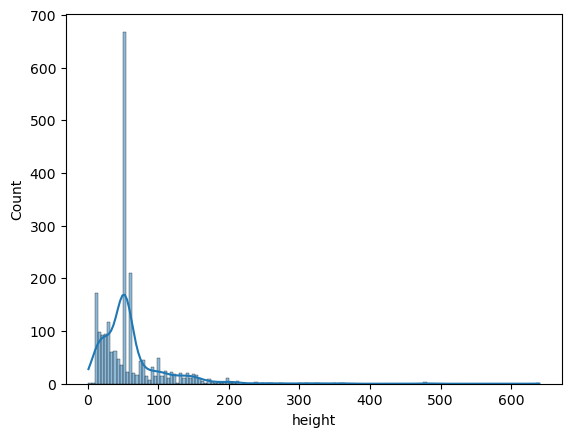

In [10]:
sns.histplot(data=X_train, x="height", kde=True)

In [11]:
# Scaling data using minmax scaler. Not using standard scaler because I don't want to change data distribution
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_minmax_np = scaler.fit_transform(X_train)
X_test_minmax_np = scaler.transform(X_test)
X_train_minmax_scaled = pd.DataFrame(X_train_minmax_np, index=X_train.index, columns=X_train.columns)
X_test_minmax_scaled = pd.DataFrame(X_test_minmax_np, index=X_test.index, columns=X_test.columns)

<AxesSubplot:xlabel='height', ylabel='Count'>

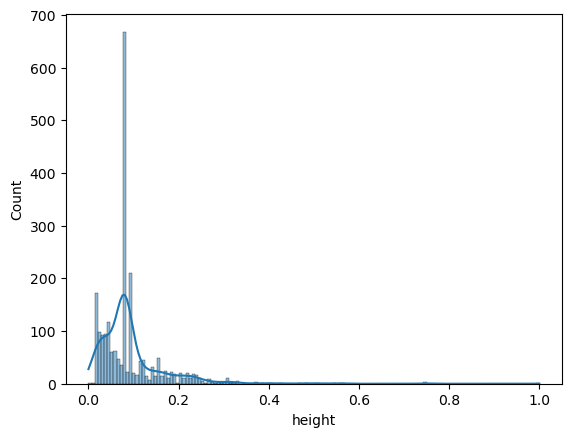

In [12]:
sns.histplot(data=X_train_minmax_scaled, x="height", kde=True)

Question 3: Train and evaluate a randomeforrest classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [13]:
parameters = {
    "max_depth": [2, 4],
    "min_samples_split": [0.05, 0.1, 0.2],
    "n_estimators": [10, 50, 100, 150],
    "criterion": ['gini', 'entropy', 'log_loss']
#     "min_samples_leaf": [0.05, 0.1, 0.15, 0.2]
}

rf_clf = RandomForestClassifier(random_state=0)
    
dtc_grid = GridSearchCV(estimator = rf_clf, param_grid = parameters, cv = 5, return_train_score = True)
dtc_grid.fit(X_train_minmax_scaled, y_train.values.ravel())
# dtc_grid.fit(X_train, y_train.values.ravel())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2],
                         'n_estimators': [10, 50, 100, 150]},
             return_train_score=True)

In [14]:
dtc_grid.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_split': 0.05,
 'n_estimators': 10}

In [15]:
# Fitting a RandomForestClassifier with best params from grid search
rf_best = RandomForestClassifier(random_state=0, max_depth=4, min_samples_split=0.05, criterion='gini', n_estimators=10).fit(X_train_minmax_scaled, y_train.values.ravel())
# rf_best = RandomForestClassifier(random_state=0, max_depth=4, min_samples_split=0.05, criterion='gini', n_estimators=10).fit(X_train, y_train.values.ravel())

# make predictions with the trained random forest
test_z = rf_best.predict(X_test_minmax_scaled)
test_z_prob = rf_best.predict_proba(X_test_minmax_scaled)
# test_z = rf_best.predict(X_test)
# test_z_prob = rf_best.predict_proba(X_test)

# evaluate the model performance - ACCURACY AND ROC AUC
rf_acc = accuracy_score(y_test, test_z)
print("Accuracy for Random Forest:", rf_acc)
rf_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Random Forest:", rf_ras)

Accuracy for Random Forest: 0.9113573407202216
ROC-AUC score for Random Forest: 0.7174711711947285


Question 4: Train and evaluate a ExtraTrees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [16]:
parameters = {
    "max_depth": [2, 4],
    "min_samples_split": [0.05, 0.1, 0.2],
    "n_estimators": [10, 50, 100, 150],
    "criterion": ['gini', 'entropy', 'log_loss']
}

et_clf = ExtraTreesClassifier(random_state=0)
    
dtc_grid = GridSearchCV(estimator = et_clf, param_grid = parameters, cv = 5, return_train_score = True)
dtc_grid.fit(X_train_minmax_scaled, y_train.values.ravel())
# dtc_grid.fit(X_train, y_train.values.ravel())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/anaconda3/lib/python3.9/site-packages

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2],
                         'n_estimators': [10, 50, 100, 150]},
             return_train_score=True)

In [17]:
dtc_grid.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_split': 0.05,
 'n_estimators': 150}

In [18]:
et_best = ExtraTreesClassifier(random_state=0, max_depth=4, min_samples_split=0.05, criterion='gini', n_estimators=150).fit(X_train_minmax_scaled, y_train.values.ravel())
# et_best = ExtraTreesClassifier(random_state=0, max_depth=2, min_samples_split=0.05, criterion='gini', min_samples_leaf=0.05, n_estimators=10).fit(X_train, y_train.values.ravel())

# make predictions with the trained random forest
test_z = et_best.predict(X_test_minmax_scaled)
test_z_prob = et_best.predict_proba(X_test_minmax_scaled)
# test_z = et_best.predict(X_test)
# test_z_prob = et_best.predict_proba(X_test)

# evaluate the model performance - ACCURACY AND ROC AUC
et_acc = accuracy_score(y_test, test_z)
print("Accuracy for Extra Trees:", et_acc)
et_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Extra Trees:", et_ras)

Accuracy for Extra Trees: 0.8975069252077562
ROC-AUC score for Extra Trees: 0.67256099155401


Question 5: Train and evaluate a Gradient Boosted Trees classifier using the following gridsearch parameters:
- "max_depth": [2, 4],
- "min_samples_split": [0.05, 0.1, 0.2]

In [19]:
parameters = {
    "max_depth": [2, 4],
    "min_samples_split": [0.05, 0.1, 0.2],
    "n_estimators": [10, 50, 100, 150],
    "criterion": ['friedman_loss', 'squared_error'],
    "loss": ['log_loss', 'deviance', 'exponential'],
    "learning_rate": [0.001, 0.01, 0.1]
}

gbt_clf = GradientBoostingClassifier(random_state=0)
    
dtc_grid = GridSearchCV(estimator = gbt_clf, param_grid = parameters, cv = 5, return_train_score = True)
dtc_grid.fit(X_train_minmax_scaled, y_train.values.ravel())
# dtc_grid.fit(X_train, y_train.values.ravel())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1440 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 525, in fit
    self._check_params()
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 282, in _check_params
    raise ValueError("Loss '{0:s}' not supported. ".format(self.loss))
ValueError:

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'criterion': ['friedman_loss', 'squared_error'],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'loss': ['log_loss', 'deviance', 'exponential'],
                         'max_depth': [2, 4],
                         'min_samples_split': [0.05, 0.1, 0.2],
                         'n_estimators': [10, 50, 100, 150]},
             return_train_score=True)

In [20]:
dtc_grid.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'exponential',
 'max_depth': 4,
 'min_samples_split': 0.05,
 'n_estimators': 150}

In [21]:
gbt_best = GradientBoostingClassifier(random_state=0, max_depth=4, min_samples_split=0.05, criterion='squared_error', n_estimators=150, loss='exponential', learning_rate=0.1).fit(X_train_minmax_scaled, y_train.values.ravel())
# gbt_best = GradientBoostingClassifier(random_state=0, max_depth=2, min_samples_split=0.2, class_weight='balanced_subsample', criterion='entropy', min_samples_leaf=0.05, n_estimators=50).fit(X_train, y_train.values.ravel())

# make predictions with the trained random forest
test_z = gbt_best.predict(X_test_minmax_scaled)
test_z_prob = gbt_best.predict_proba(X_test_minmax_scaled)
# test_z = gbt_best.predict(X_test)
# test_z_prob = gbt_best.predict_proba(X_test)

# evaluate the model performance - ACCURACY AND ROC AUC
gbt_acc = accuracy_score(y_test, test_z)
print("Accuracy for Gradient Boosted Trees:", gbt_acc)
gbt_ras = roc_auc_score(y_test, test_z)
print("ROC-AUC score for Gradient Boosted Trees:", gbt_ras)

Accuracy for Gradient Boosted Trees: 0.9566020313942751
ROC-AUC score for Gradient Boosted Trees: 0.8788667207070575


[Bonus] Question 6: Which algorithm performed better and why?


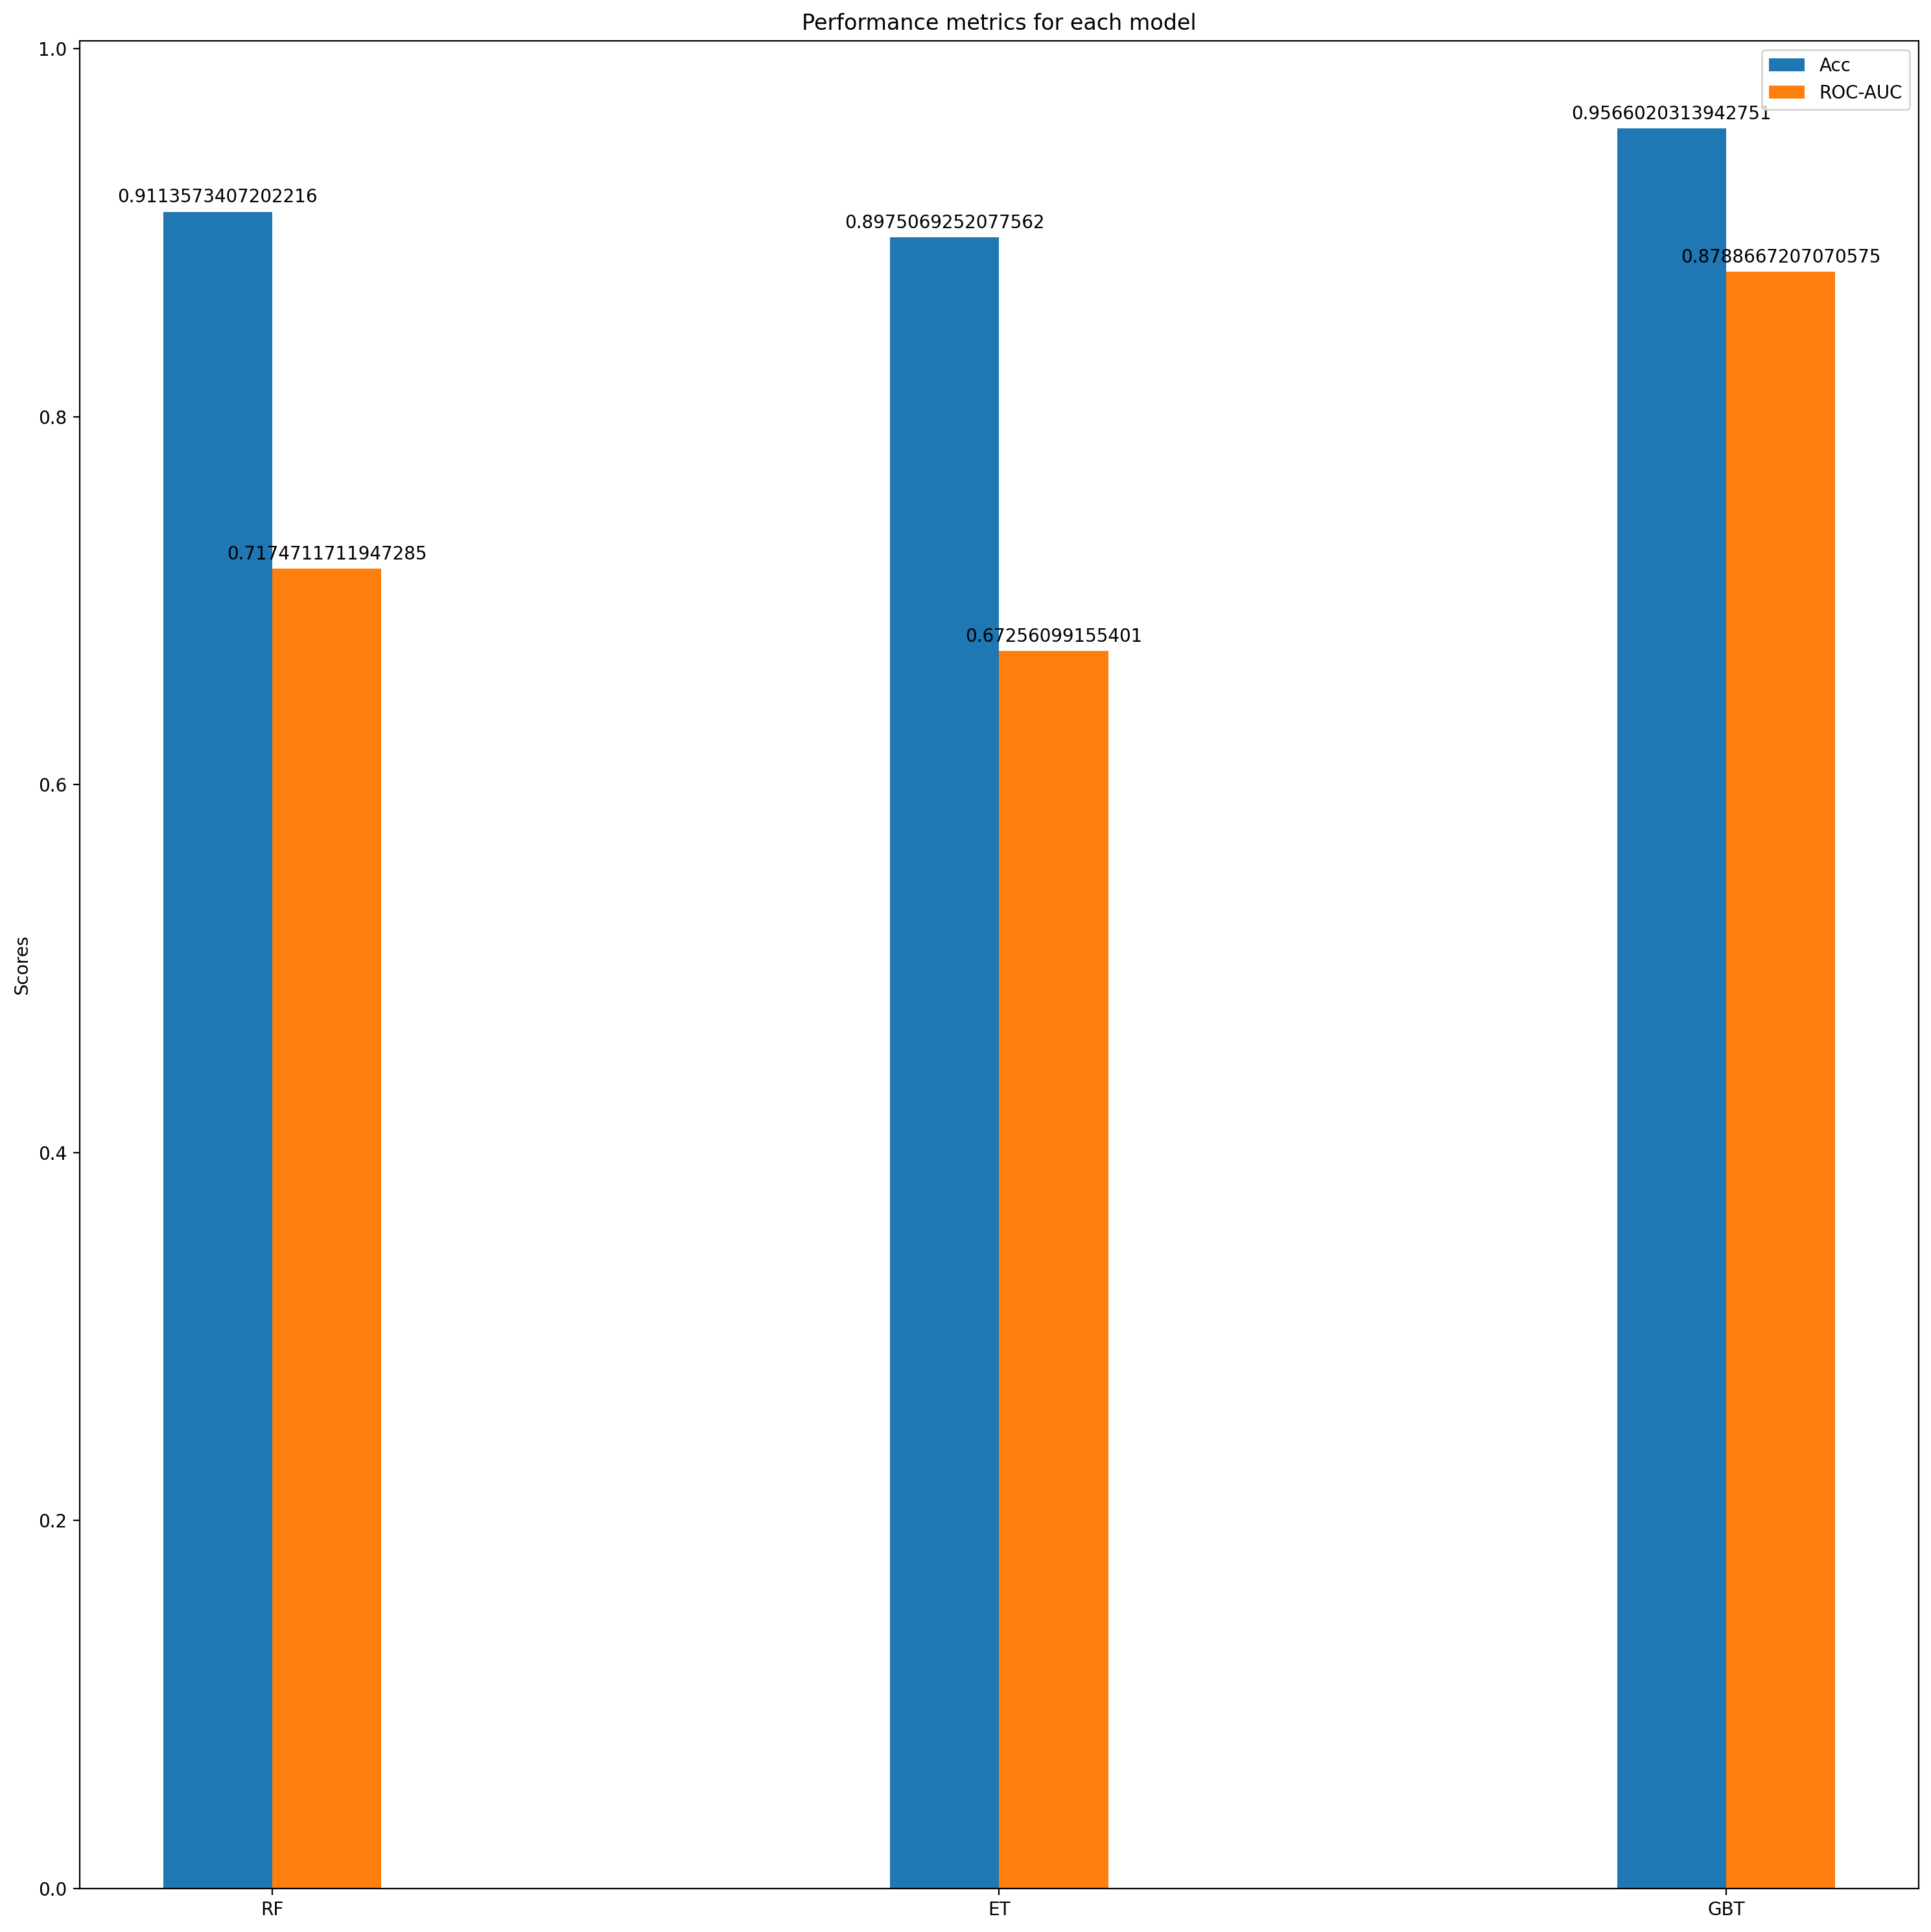

In [22]:
# Compare performance
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200

models = ("RF", "ET", "GBT")
accuracy = [rf_acc, et_acc, gbt_acc]
roc_auc = [rf_ras, et_ras, gbt_ras]

x = np.arange(len(models))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width, label='Acc')
rects2 = ax.bar(x + width/2, roc_auc, width, label='ROC-AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance metrics for each model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Gradient Boosting sequentially improves upon the errors of previously generated trees, by creating new trees that focus on fixing mistakes in the previous trees. This allows Gradient Boosting to adapt to complex and non-linear patterns in the data, making it well-suited for a wide range of classification problems. Also, GB allows the use of various other loss functions, better control and flexibility with learning rate where as Random Forests and Extra Trees don't allow this.

Extra Trees rely on randomly selecting subsets of features, samples and thresholds to construct a large number of decision trees. This might generate a certain level of randomness which may lead to overfitting/underfitting of the data.

Random Forest builds its trees by selecting a random subset of features at each node of the tree, then choosing the best split among those features. Extra Trees builds its trees by selecting random features and random thresholds for each feature, without attempting to find the best split. This means Random Forest tends to create decision trees with lower variance than Extra Trees, which means better generalization/less overfitting than Extra Trees.

Random forest also uses a combination of bagging and feature selection helping to reduce the correlation among the trees, ensuring that each tree makes independent and diverse predictions. This helps to reduce variance and improve accuracy. Extra Trees don't do bagging.

Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.

Incoming experience: No incoming experience apart from previous assignments and a data structure knowledge of trees and forests

Steps taken: This week's lesson was about ensemble models. Used Scikit Learn's libraries for binary classification on the data set to get a deeper understanding of the concepts. Explored the different classifiers' hyper parameters.

Obstacles: I wanted to tune all the hyper parameters that I could make sense of. Took a while to grid search all of the parameters and tune them. I realized in the grid search, adding min samples leaf in the search criteria reduced accuracy and ROC-AUC score. Maybe the algorithm does better when min samples at leaf is not specified.

Link to real world: Helped me understand how the different classifier libraries are used and how grid search can be used. 

Steps missing (with just this week's learning): Data needed to be scaled